In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

import timm
from torchvision import transforms

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [26]:
CFG = {
          "epochs": 20,
          "img_size": 256,
          "model_name": "resnet50d",
          "num_classes": 15587,
          "train_batch_size": 64,
          "valid_batch_size": 64,
          "lr": 1e-3,
          "num_workers": 8,
          "min_lr": 1e-6,
#           "T_max": 500,
#           "weight_decay": 1e-6,
          "folder": "test",
          "n_fold": 5,
          "fold_number": 0,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
#           # ArcFace Hyperparameters
#           "s": 30.0, 
#           "m": 0.50,
#           "ls_eps": 0.0,
#           "easy_margin": False
          }

In [4]:
PATH = '/home/haohe/kaggle/whale'
train_data = PATH + '/data/img_256/train_images-256-256/train_images-256-256'
test_data = PATH + '/data/img_256/test_images-256-256/test_images-256-256'
df_train = pd.read_csv(PATH + '/data/raw_data/train.csv')
df_test = pd.read_csv(PATH + '/data/raw_data/sample_submission.csv')

In [5]:
df_train.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


In [6]:
gkf = GroupKFold(n_splits=5)

df_train.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(gkf.split(X=df_train.index, y=df_train['individual_id'], groups=df_train['image'])):
    df_train.loc[df_train.iloc[val_index].index, 'fold'] = fold_number

In [7]:
encoder = LabelEncoder()
df_train['label'] = encoder.fit_transform(df_train['individual_id'])

In [8]:
df_train.head()

,image,species,individual_id,fold,label
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,2,12348
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,4,1636
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,3,5842
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,2,4551
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,1,8721


In [9]:
len(df_train.individual_id.unique())

15587

In [10]:
encoder.inverse_transform([12348])

array(['cadddb1636b9'], dtype=object)

In [11]:
class WhaleDataset(Dataset):
    def __init__(self,path,df,transforms=None):
        super().__init__()
        self.path = path
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        fname, label = self.df.iloc[idx]['image'], self.df.iloc[idx]['label']
        image = cv2.imread(f'{self.path}/{fname}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            aug = self.transforms(
                image = image,
            )
            image = aug['image']
        return image, torch.tensor(label, dtype=torch.long)

In [12]:
def get_train_transform():
    return A.Compose([
        A.Resize(CFG['img_size'], CFG['img_size']),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9),
        A.Blur(blur_limit=3,p=0.2),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)

def get_valid_transform():
    return A.Compose([
        A.Resize(CFG['img_size'], CFG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)

In [13]:
train_dataset = WhaleDataset(
    path = train_data,
    df = df_train[df_train['fold'] != CFG['fold_number']],
    transforms=get_train_transform(),
)

validation_dataset = WhaleDataset(
    path = train_data,
    df = df_train[df_train['fold'] == CFG['fold_number']],
    transforms=get_valid_transform(),
)

In [14]:
def denormalize(x:torch.tensor):
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])
    return x * std[...,None,None] + mean[...,None,None]

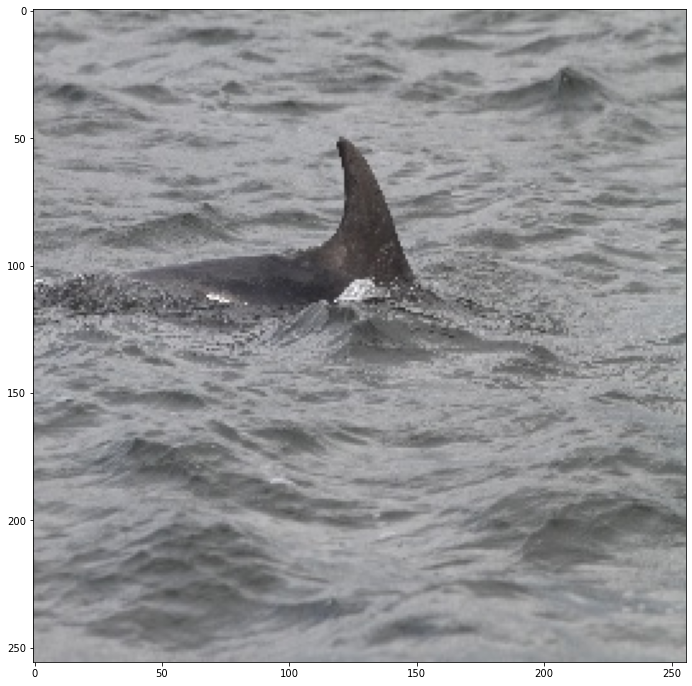

In [15]:
image, target = validation_dataset[0]

image = denormalize(image)

image = image.permute(1,2,0).numpy()

_, ax = plt.subplots(1, 1, figsize=(16,12))
ax.imshow(image)

In [16]:
encoder.inverse_transform([target])

array(['b9907151f66e'], dtype=object)

In [17]:
# Metric MAP@5
def map5kfast(preds, targs, k=10):
    predicted_idxs = preds.sort(descending=True)[1]
    top_5 = predicted_idxs[:, :5]
    scores = torch.zeros(len(preds), k).float()
    for kk in range(k):
        scores[:,kk] = (top_5[:,kk] == targs).float() / float((kk+1))
    return scores.max(dim=1)[0].mean()

def map5(preds,targs):
    if type(preds) is list:
        raise Exception('Not Implemented... ')
    return map5kfast(preds,targs, 5)

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [19]:
import warnings

warnings.filterwarnings("ignore")



class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        
        self.base_dir = f'{PATH}/model/{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
            
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.criterion = nn.CrossEntropyLoss().to(self.device)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, final_scores = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, final_scores = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            if final_scores.avg < self.best_summary_loss:
                self.best_summary_loss = final_scores.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=final_scores.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        final_scores = AverageMeter()
        t = time.time()
        for step, (images, targets) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                targets = targets.to(self.device).long()
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                top5_acc = map5(outputs,targets)
                final_scores.update(top5_acc.detach().item(), batch_size)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss, final_scores

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        final_scores = AverageMeter()
        t = time.time()
        for step, (images, targets) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            targets = targets.to(self.device).long()
            images = images.to(self.device).float()
            batch_size = images.shape[0]

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)
            
            loss.backward()
            
            top5_acc = map5(outputs,targets)
            final_scores.update(top5_acc.detach().item(), batch_size)
            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss, final_scores
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [20]:
model = timm.create_model(CFG['model_name'],pretrained=True,num_classes=CFG['num_classes']).cuda()

In [21]:
class TrainGlobalConfig:
    num_workers = CFG['num_workers']
    batch_size = CFG['train_batch_size'] 
    n_epochs = CFG['epochs']
    lr = CFG['lr']
    
    folder = CFG['folder']

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = True  # do scheduler.step after optimizer.step
    validation_scheduler = False  # do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    scheduler_params = dict(
        max_lr=lr,
        epochs=n_epochs,
        steps_per_epoch=int(len(train_dataset) / batch_size),
        pct_start=0.3,
        anneal_strategy='cos', 
        final_div_factor=10**5
    )

In [22]:
def run_training():
    device = torch.device('cuda:0')

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=TrainGlobalConfig.batch_size,
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
    )

    fitter = Fitter(model=model, device=device, config=TrainGlobalConfig)
#     fitter.load(f'{fitter.base_dir}/last-checkpoint.bin')
    fitter.fit(train_loader, val_loader)

In [23]:
run_training()

Fitter prepared. Device is cuda:0

2022-02-20T21:08:56.776861
LR: 3.9999999999999996e-05
[RESULT]: Train. Epoch: 0, summary_loss: 8.70031, final_score: 0.01351, time: 273.67175
[RESULT]: Val. Epoch: 0, summary_loss: 8.18601, final_score: 0.02604, time: 22.61217

2022-02-20T21:13:57.253473
LR: 0.00010434069773506576
[RESULT]: Train. Epoch: 1, summary_loss: 7.28573, final_score: 0.04551, time: 246.35122
[RESULT]: Val. Epoch: 1, summary_loss: 7.54603, final_score: 0.06613, time: 24.45195

2022-02-20T21:18:29.868263
LR: 0.0002801139351692834
[RESULT]: Train. Epoch: 2, summary_loss: 5.63937, final_score: 0.10768, time: 251.15248
[RESULT]: Val. Epoch: 2, summary_loss: 7.35621, final_score: 0.11685, time: 24.90285

2022-02-20T21:23:08.017644
LR: 0.0005201973258873657
[RESULT]: Train. Epoch: 3, summary_loss: 3.62163, final_score: 0.29722, time: 252.65134
[RESULT]: Val. Epoch: 3, summary_loss: 8.26225, final_score: 0.14911, time: 24.41070

2022-02-20T21:27:47.088798
LR: 0.0007602278162501385
[R

In [27]:
model.eval()
torch.save({
            'model_state_dict': model.state_dict(),
        }, f'{PATH}/model/{CFG["folder"]}/resnet50d_baseline.bin')

# Fin